# Data Analytics, Autumn 2024
## Assignment 3
#### Team Members:
* Hardik Soni (20CS30023)
* Astitva (20CS30007)
* Sake Venkata Vighan Kumar (20CS10052)

In [1]:
! pip install surprise --quiet

In [2]:
from kaggle_secrets import UserSecretsClient
from concurrent.futures import ProcessPoolExecutor
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from collections import namedtuple
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import random
import os
import re
import asyncio
import aiohttp
import requests

In [3]:
user_secrets = UserSecretsClient()
API_KEY = user_secrets.get_secret("tmdb_api_key")

## Task 1: Finding Top Actors for Each Movie

In [4]:
# Load the datasets
links = pd.read_csv('/kaggle/input/movies-dataset/ml-32m/links_set1.csv')
movies = pd.read_csv('/kaggle/input/movies-dataset/ml-32m/movies_set1.csv')

# Merge DataFrames on the 'movieId' column
combined_df = pd.merge(movies, links, on='movieId', how='inner')

# Display the updated DataFrame
combined_df

,movieId,title,genres,imdbId,tmdbId
0,120510,Value for Money (1955),Comedy|Romance,48772,171394.0
1,212955,Face of Evil (1996),Drama|Thriller,116264,268881.0
2,193912,Spring 1941 (2007),Drama|Romance|War,1252616,53604.0
3,163921,Wolf Creek (2016),Crime|Horror|Thriller,4460878,388131.0
4,126652,Raven the Little Rascal (2012),Animation|Children,1695770,142638.0
...,...,...,...,...,...
19995,216811,Song Without a Name (2020),Drama,1824932,582925.0
19996,171417,Şabaniye (1984),Comedy|Drama|Romance,253616,327935.0
19997,220072,Ellen DeGeneres: Here and Now (2003),Comedy,365156,19511.0
19998,32329,Paradise Alley (1978),Drama,78056,23916.0


In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  20000 non-null  int64  
 1   title    20000 non-null  object 
 2   genres   20000 non-null  object 
 3   imdbId   20000 non-null  int64  
 4   tmdbId   19980 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 781.4+ KB


In [6]:
async def search_movie_by_title(title):
    """Search for a movie by title if tmdbId is missing."""
    try:
        url = f'https://api.themoviedb.org/3/search/movie'
        params = {'api_key': API_KEY, 'query': title}
        
        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params) as response:
                if response.status == 200:
                    data = await response.json()
                    results = data.get('results', [])
                    if results:
                        return results[0]['id']  # Return the first result's TMDb ID
    except Exception as e:
        return []

async def search_movie_by_imdb_id(imdb_id):
    """Search for a movie using IMDb ID."""
    try:
        url = f'https://api.themoviedb.org/3/find/{imdb_id}'
        params = {'api_key': API_KEY, 'external_source': 'imdb_id'}
        
        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params) as response:
                if response.status == 200:
                    data = await response.json()
                    movie_results = data.get('movie_results', [])
                    if movie_results:
                        return movie_results[0]['id']  # Return the first result's TMDb ID
    except Exception as e:
        return []

async def fetch_cast(tmdb_id, title=None, imdb_id=None):
    """Fetch top 10 cast members for a movie by TMDb ID, IMDb ID, or title."""
    try:
        # Attempt using TMDb ID if provided
        if not pd.isna(tmdb_id):
            url = f'https://api.themoviedb.org/3/movie/{int(tmdb_id)}?api_key={API_KEY}&append_to_response=credits'
            async with aiohttp.ClientSession() as session:
                async with session.get(url) as response:
                    if response.status == 200:
                        data = await response.json()
                        return extract_cast(data)  # Extract and return the cast
                    # print(f"Failed to fetch data using tmdb_id: {tmdb_id}, status: {response.status}")

        # Fallback: Attempt using IMDb ID
        if imdb_id:
            tmdb_id = await search_movie_by_imdb_id(imdb_id)
            if tmdb_id:
                url = f'https://api.themoviedb.org/3/movie/{int(tmdb_id)}?api_key={API_KEY}&append_to_response=credits'
                async with aiohttp.ClientSession() as session:
                    async with session.get(url) as response:
                        if response.status == 200:
                            data = await response.json()
                            return extract_cast(data)  # Extract and return the cast
                        # print(f"Failed to fetch data using imdb_id: {imdb_id}, status: {response.status}")

        # Fallback: Attempt using Title
        if title:
            tmdb_id = await search_movie_by_title(title)
            if tmdb_id is None:
                # Retry by removing year from the title
                title_without_year = re.sub(r"\s*\(\d{4}\)", "", title)
                tmdb_id = await search_movie_by_title(title_without_year)

            if tmdb_id:
                url = f'https://api.themoviedb.org/3/movie/{int(tmdb_id)}?api_key={API_KEY}&append_to_response=credits'
                async with aiohttp.ClientSession() as session:
                    async with session.get(url) as response:
                        if response.status == 200:
                            data = await response.json()
                            return extract_cast(data)  # Extract and return the cast
                        # print(f"Failed to fetch data using title: {title}, status: {response.status}")

        # If all methods fail, return None
        # print(f"Failed to retrieve cast for movie: title='{title}', imdb_id='{imdb_id}', tmdb_id='{tmdb_id}'")
        return []

    except Exception as e:
        # print(f"Error in fetch_cast: {e}")
        return []

def extract_cast(data):
    """Extract top 10 cast members from the movie data."""
    cast_data = data.get('credits', {}).get('cast', [])
    sorted_cast = sorted(cast_data, key=lambda x: x['popularity'], reverse=True)
    top_actors = [actor['name'] for actor in sorted_cast[:10]]
    return top_actors

async def process_movie_chunk(movie_chunk):
    tasks = []
    for index, row in movie_chunk.iterrows():
        tasks.append(fetch_cast(row['tmdbId'], row['title'], row.get('imdbId')))
    results = await asyncio.gather(*tasks)
    return results

def run_async_task(movie_chunk):
    return asyncio.run(process_movie_chunk(movie_chunk))

def main(combined_df):
    # Split the DataFrame into chunks for each process
    num_processes = os.cpu_count()
    chunk_size = len(combined_df) // num_processes
    chunks = [combined_df.iloc[i:i + chunk_size] for i in range(0, len(combined_df), chunk_size)]
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        results = list(executor.map(run_async_task, chunks))
    # Flatten and assign results to the original DataFrame
    combined_df['top_actors'] = [actor for chunk_result in results for actor in chunk_result]
    return combined_df

In [7]:
# Run the function and add the 'top_actors' column
tic = time.time()
updated_df = main(combined_df)
updated_df
print(f"Time to Extract Actor Data: {time.time()-tic} seconds")

Time to Extract Actor Data: 302.75047612190247 seconds


In [8]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   movieId     20000 non-null  int64  
 1   title       20000 non-null  object 
 2   genres      20000 non-null  object 
 3   imdbId      20000 non-null  int64  
 4   tmdbId      19980 non-null  float64
 5   top_actors  20000 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 937.6+ KB


In [9]:
updated_df

,movieId,title,genres,imdbId,tmdbId,top_actors
0,120510,Value for Money (1955),Comedy|Romance,48772,171394.0,"[Donald Pleasence, Oliver Reed, Leslie Phillip..."
1,212955,Face of Evil (1996),Drama|Thriller,116264,268881.0,"[Shawnee Smith, Perry King, Melissa Moore, Mir..."
2,193912,Spring 1941 (2007),Drama|Romance|War,1252616,53604.0,[]
3,163921,Wolf Creek (2016),Crime|Horror|Thriller,4460878,388131.0,[]
4,126652,Raven the Little Rascal (2012),Animation|Children,1695770,142638.0,"[Katharina Thalbach, Anna Thalbach, Constantin..."
...,...,...,...,...,...,...
19995,216811,Song Without a Name (2020),Drama,1824932,582925.0,[]
19996,171417,Şabaniye (1984),Comedy|Drama|Romance,253616,327935.0,"[Kemal Sunal, Erdal Özyağcılar, Adile Naşit, R..."
19997,220072,Ellen DeGeneres: Here and Now (2003),Comedy,365156,19511.0,[]
19998,32329,Paradise Alley (1978),Drama,78056,23916.0,[]


In [10]:
# Flatten the 'top_actors' column into individual rows along with 'movieId'
movie_actors = [
    {'movieId': row['movieId'], 'top_actor': actor}
    for _, row in updated_df.iterrows()
    for actor in row['top_actors']
]

# Convert the list of dictionaries into a DataFrame
movies_actors_df = pd.DataFrame(movie_actors)
print(movies_actors_df)

       movieId         top_actor
0       120510  Donald Pleasence
1       120510       Oliver Reed
2       120510   Leslie Phillips
3       120510        Diana Dors
4       120510      Joan Hickson
...        ...               ...
21631   171417     Reha Yurdakul
21632   171417        İhsan Yüce
21633   171417     Turgut Boralı
21634   171417        Aliye Rona
21635   171417       Çiğdem Tunç

[21636 rows x 2 columns]


## Task 2: Constructing the User-Actor Rating Matrix

In [11]:
# Load the necessary data files
ratings_df = pd.read_csv('/kaggle/input/movies-dataset/ml-32m/ratings_set1.csv')

# Merge the ratings with movie-actor associations
user_ratings = ratings_df.merge(movies_actors_df, on="movieId")

# Calculate the average rating for each user-actor pair
user_actor_ratings = user_ratings.groupby(['userId', 'top_actor']).agg({'rating': 'mean'}).reset_index()
user_actor_ratings

,userId,top_actor,rating
0,5,Chris O'Donnell,3.0
1,5,Debi Mazar,3.0
2,5,Drew Barrymore,3.0
3,5,Ed Begley Jr.,3.0
4,5,Jessica Tuck,3.0
...,...,...,...
269798,200928,Tobin Bell,4.0
269799,200928,Tony Sirico,4.0
269800,200928,Valentina Vargas,4.0
269801,200928,Vernon Dobtcheff,4.0


Rating Description:
count    269803.000000
mean          3.520572
std           1.101040
min           0.500000
25%           3.000000
50%           3.500000
75%           4.500000
max           5.000000
Name: rating, dtype: float64


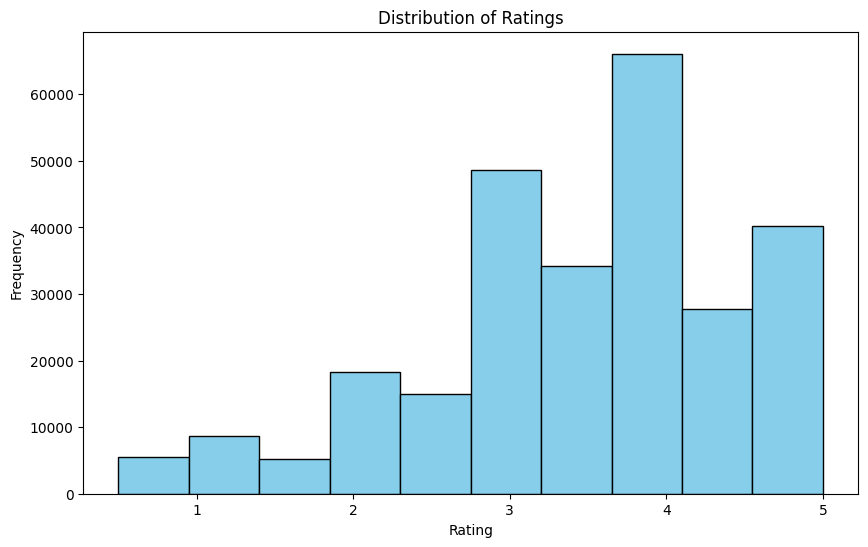

User ID Counts:
userId
147603    1238
56703     1055
48454     1029
5029       923
52603      897
101654     887
75040      840
20110      720
16283      671
69447      655
Name: count, dtype: int64


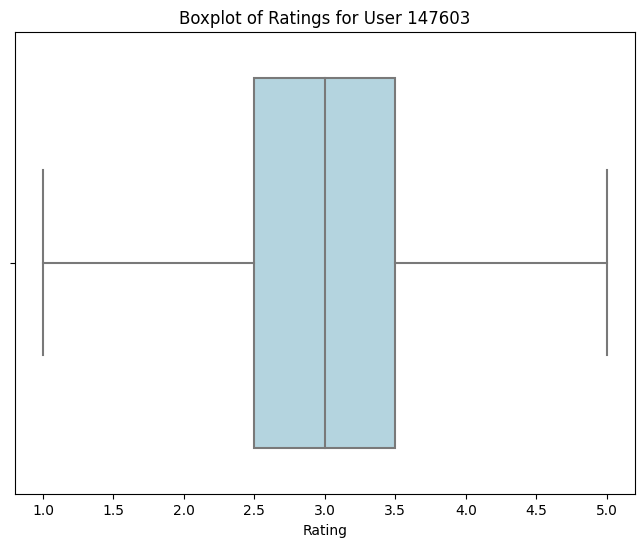

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


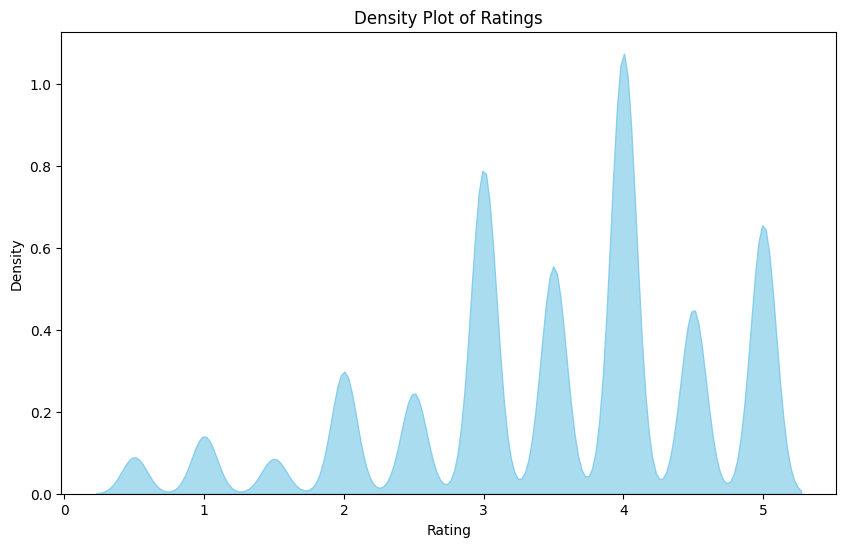

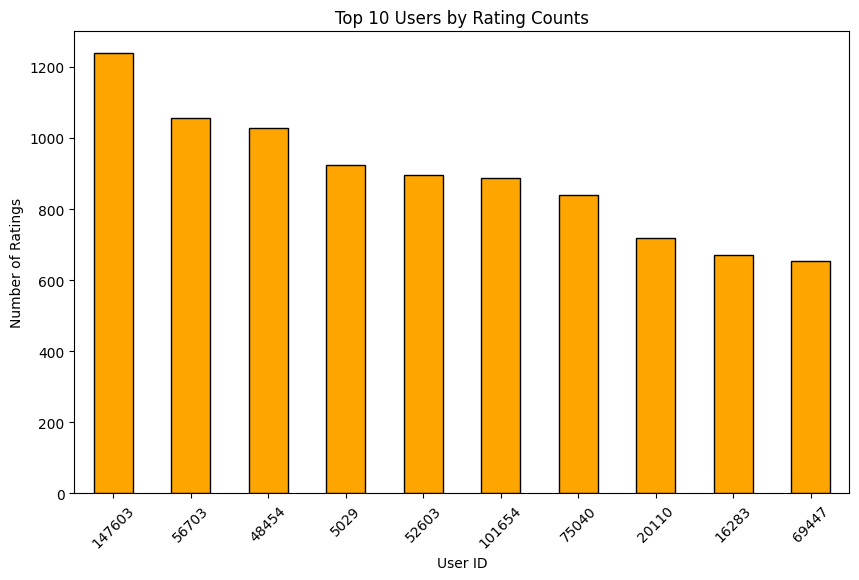

top_actor
John Bryant             5.0
Sabine Pakora           5.0
Paul Frees              5.0
Liu Hua                 5.0
Lionel Erdogan          5.0
Pepa Aniorte            5.0
Anders W. Berthelsen    5.0
Philippe Gautier        5.0
Phyllis Posnick         5.0
Pilou Asbæk             5.0
Emilio Buale            5.0
Polly Allen Mellen      5.0
Emilia Fox              5.0
Lev Potyomkin           5.0
Leslie Ash              5.0
Huang Bo                5.0
Eduard Nazarov          5.0
Lei Jiayin              5.0
Dorothy Malone          5.0
Robert Kirkman          5.0
Name: rating, dtype: float64


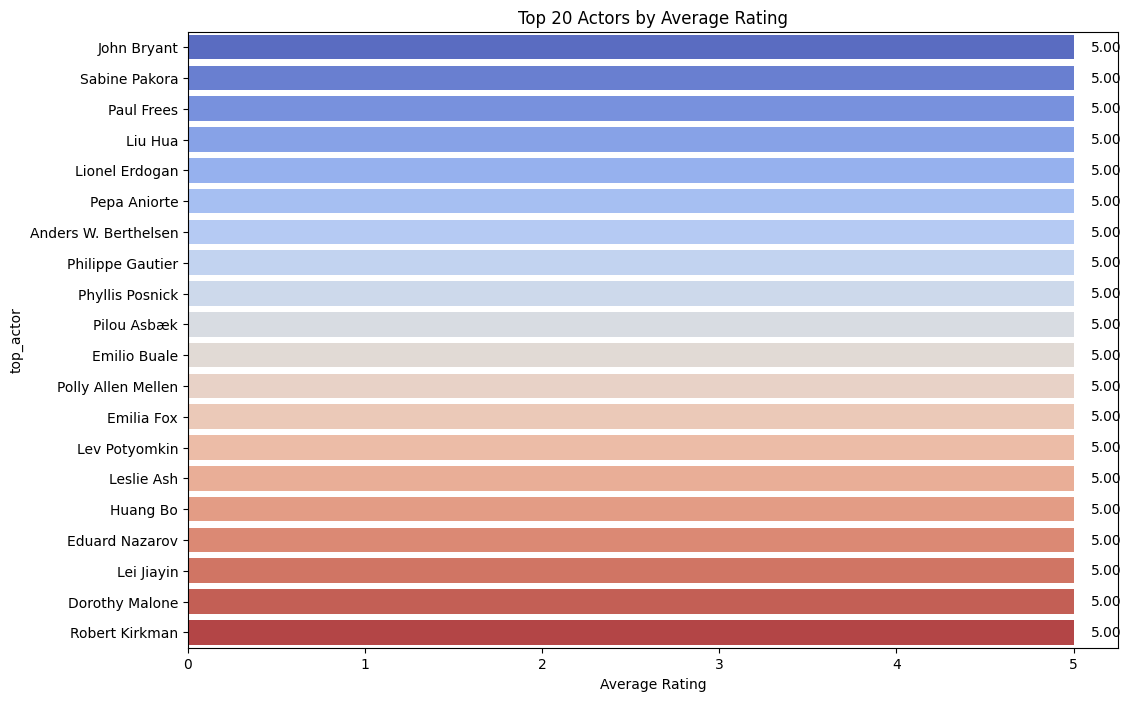

In [12]:
# 1. Check Rating Variability
print("Rating Description:")
print(user_actor_ratings['rating'].describe())

# 2. Check Distribution of Ratings
plt.figure(figsize=(10, 6))
plt.hist(user_actor_ratings['rating'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

# 3. Explore Unique User IDs and Their Counts
user_counts = user_actor_ratings['userId'].value_counts()
print("User ID Counts:")
print(user_counts.head(10))  # Display the top 10 users with the most ratings

# Choose a sample user with enough ratings for visualization
sample_user_id = user_counts.idxmax()  # This picks the user with the most ratings

# Filter user ratings for the sample user
user_ratings = user_actor_ratings[user_actor_ratings['userId'] == sample_user_id]

# Visualization 1: Boxplot for Rating Variability of the Sample User
plt.figure(figsize=(8, 6))
sns.boxplot(x=user_ratings['rating'], color='lightblue')  # Filtered for the sample user
plt.xlabel('Rating')
plt.title(f'Boxplot of Ratings for User {sample_user_id}')
plt.show()

# Example: KDE Plot for Rating Distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(user_actor_ratings['rating'], fill=True, color='skyblue', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Density Plot of Ratings')
plt.show()

# Example: Bar Plot for Top 10 Users by Rating Counts
plt.figure(figsize=(10, 6))
user_counts.head(10).plot(kind='bar', color='orange', edgecolor='black')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.title('Top 10 Users by Rating Counts')
plt.xticks(rotation=45)
plt.show()

# 4. Visualization 2: Distribution of Average Actor Ratings
actor_avg_ratings = user_actor_ratings.groupby('top_actor')['rating'].mean().sort_values(ascending=False).head(20)
print(actor_avg_ratings)

if not actor_avg_ratings.empty:   
    # Example: Bar Plot for Top 20 Actors by Average Rating
    plt.figure(figsize=(12, 8))
    sns.barplot(x=actor_avg_ratings.values, y=actor_avg_ratings.index, palette='coolwarm')
    plt.xlabel('Average Rating')
    plt.title('Top 20 Actors by Average Rating')
    for i, v in enumerate(actor_avg_ratings.values):
        plt.text(v + 0.1, i, f"{v:.2f}", va='center')
    plt.show()
else:
    print("No data available for actor ratings.")

## Task 3: Choosing a Recommendation Algorithm

In [13]:
# Load the user-actor ratings into Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(user_actor_ratings[['userId', 'top_actor', 'rating']], reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Initialize and train the SVD model
model = SVD()
model.fit(trainset)

# Evaluate performance on the test set
test_predictions = model.test(testset)

accuracy.rmse(test_predictions)
accuracy.mae(test_predictions)
print("Recommender Model Training Done !")

RMSE: 0.4636
MAE:  0.2990
Recommender Model Training Done !


## Task 4: Implementing the Recommendation System

In [14]:
# Function to get top actor recommendations for a given user
def recommend_top_actors(user_id, model, data, top_n=10):
    # Retrieve a list of unique actors from the dataset
    unique_actors = data.df['top_actor'].drop_duplicates().values
    # Generate prediction ratings for the user across all actors
    predictions = [model.predict(user_id, actor) for actor in unique_actors]
    # Sort the predictions based on the estimated ratings in descending order
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
    # Extract the top N actors and their predicted ratings
    top_actor_recs = [(prediction.iid, prediction.est) for prediction in sorted_predictions[:top_n]]
    
    # Convert the top recommendations to a DataFrame for easier reporting
    recommendations_df = pd.DataFrame(top_actor_recs, columns=['Actor', 'Predicted Rating'])
    return recommendations_df

# Example usage
user_id = 1  # Replace with an actual user ID
top_actors_df = recommend_top_actors(user_id, model, data, top_n=5)

# Display the top recommended actors in a DataFrame
print(top_actors_df)

                  Actor  Predicted Rating
0         Safit Pardede          4.295516
1  Yapto Soerjosoemarno          4.283894
2             Haji Anif          4.272865
3        Kim Joo-ryoung          4.226700
4           Jung In-sun          4.201680


In [15]:
# Define the function to calculate Precision@k and Recall@k
def calculate_precision_recall_at_k(predictions, k=10, rating_threshold=4.0):
    user_recommendations = defaultdict(list)
    
    # Organize predictions by user and mark relevant ratings
    for user_id, _, actual_rating, predicted_rating, _ in predictions:
        user_recommendations[user_id].append((predicted_rating, actual_rating >= rating_threshold))

    precision_scores, recall_scores = [], []

    # Calculate precision and recall for each user
    for user_id, ratings in user_recommendations.items():
        ratings.sort(key=lambda x: x[0], reverse=True)  # Sort by predicted rating
        top_k_ratings = ratings[:k]
        relevant_ratings = sum((r[1] for r in ratings))  # Number of relevant items

        if relevant_ratings:
            precision = sum((r[1] for r in top_k_ratings)) / k
            recall = sum((r[1] for r in top_k_ratings)) / relevant_ratings
            precision_scores.append(precision)
            recall_scores.append(recall)

    # Return average precision, recall, and the recommendations per user
    return np.mean(precision_scores), np.mean(recall_scores), user_recommendations


# Define the function to calculate NDCG@k
def calculate_ndcg_at_k(user_recommendations, k=10):
    ndcg_values = []
    
    # Calculate NDCG for each user
    for user_id, ratings in user_recommendations.items():
        ratings.sort(key=lambda x: x[0], reverse=True)
        dcg = sum((r[1] / np.log2(i + 2)) for i, r in enumerate(ratings[:k]))
        idcg = sum((1 / np.log2(i + 2)) for i in range(len(ratings[:k])))
        ndcg_values.append(dcg / idcg if idcg > 0 else 0)

    # Return the average NDCG score
    return np.mean(ndcg_values)

In [16]:
# Example usage with predictions data
precision, recall, user_recs = calculate_precision_recall_at_k(test_predictions, k=5)
print("Precision@5:", precision)
print("Recall@5:", recall)

# Calculate and print NDCG@k
ndcg = calculate_ndcg_at_k(user_recs, k=5)
print("NDCG@5:", ndcg)


Precision@5: 0.6984200547714347
Recall@5: 0.8365714125594278
NDCG@5: 0.7114273693450804


In a recommendation system, **Precision**, **Recall**, and **NDCG (Normalized Discounted Cumulative Gain)** are different metrics used to evaluate the quality of recommendations. Whether high recall, precision, or NDCG is considered "good" depends on the goals and context of the recommendation system. Here’s a breakdown of each:

### 1. **Precision**:
   - **Definition**: Precision measures the proportion of relevant items among the recommended items. In other words, how many of the recommended items are actually useful or relevant to the user.
   - **Formula**: 
     $$\text{Precision} = \frac{\text{Number of relevant recommended items}}{\text{Number of recommended items}}$$
   - **Is High Precision Good?**
     Yes. High precision means that most of the recommended items are relevant, and users are not getting irrelevant items. However, precision doesn't account for the possibility of missing out on relevant items that weren’t recommended.

### 2. **Recall**:
   - **Definition**: Recall measures the proportion of relevant items that were actually recommended. It answers the question: How many of the relevant items were successfully included in the recommendations?
   - **Formula**: 
     $$\text{Recall} = \frac{\text{Number of relevant recommended items}}{\text{Total number of relevant items}}$$
   - **Is High Recall Good?**
     Yes, especially if the goal is to ensure that users don’t miss out on potentially relevant items. High recall means you’re recommending most of the relevant items to the users, but it might also result in recommending some irrelevant items (which can lower precision).

   **Trade-off between Precision and Recall**: 
   - Often, improving one can lead to the decline of the other. For example, if you recommend more items (higher recall), precision may decrease as some irrelevant items are included. Conversely, if you are more selective about recommendations (higher precision), you may miss some relevant items (lower recall).

### 3. **NDCG (Normalized Discounted Cumulative Gain)**:
   - **Definition**: NDCG evaluates how well the system ranks the relevant items. It takes into account the order of recommendations, giving higher weights to relevant items that appear earlier in the list.
   - **Formula**: 
     $$\text{NDCG} = \frac{DCG}{IDCG}$$
     Where DCG is the **Discounted Cumulative Gain** and IDCG is the **Ideal Discounted Cumulative Gain** (the DCG of the best possible ranking).
   - **Is High NDCG Good?**
     Yes, high NDCG indicates that the relevant items are ranked higher in the list, meaning that users are more likely to engage with the top-ranked recommendations. This is especially important when considering **ranking quality**, where just recommending a relevant item might not be enough; it needs to appear in a prominent position for the user to notice and engage with it.

### **Which One is "Better"?**
- **High Precision**: If your system prioritizes ensuring that users only see items that are truly relevant to them and you want to avoid showing irrelevant items, then **high precision** is important.
- **High Recall**: If you want to ensure that users see as many relevant items as possible (even at the cost of some irrelevant ones), then **high recall** is the goal.
- **High NDCG**: If your system is focused on ranking items such that the most relevant items appear first (i.e., the order of recommendations matters), then **high NDCG** is the best metric to optimize for.

### In General:
- **High Precision** is good when you want to minimize irrelevant recommendations.
- **High Recall** is good when you want to ensure users get as many relevant items as possible.
- **High NDCG** is particularly valuable when you care about both relevance **and** the ranking of recommendations.

**Final Goal**: Ideally, you want a balance between precision, recall, and NDCG, depending on your application:
- If you have limited recommendations to show, prioritizing **precision** may be better.
- If you have the ability to show many recommendations and want to make sure users see most of the relevant ones, **recall** would be more critical.
- If your system is ranking items, **NDCG** is often more important as it directly measures how well the order of recommendations serves the user.